In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl

import missingno as msno

import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['font.family'] = 'Malgun Gothic'

import seaborn as sns 

In [2]:
train = pd.read_csv('./train.csv', index_col = 'id')
test = pd.read_csv('./test.csv', index_col = 'id')
submission = pd.read_csv('./sample_submission.csv', index_col = 'id')

# 피처 엔지니어링

## 데이터 합치기

In [3]:
all_data=pd.concat([train,test])
all_data=all_data.drop('target',axis=1)
all_data_features=all_data.columns
all_data_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

## 명목형 피처 원-핫 인코딩

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
cat_features=[feature for feature in all_data_features if 'cat' in feature]
onehot=OneHotEncoder()
encoded_cat=onehot.fit_transform(all_data[cat_features])
encoded_cat

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

## 필요 없는 피처 제거

In [6]:
drop_features=['ps_ind_14','ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin','ps_car_14']

원- 핫 인코딩에서 사용한 피처와 제거한 피처를 제외한 피처들

In [7]:
remaining_features=[feature for feature in all_data_features
                   if('cat' not in feature and 
                     'calc' not in feature and
                     feature not in drop_features)]

In [8]:
from scipy import sparse
all_data_sprs=sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                            encoded_cat],
                           format='csr')

hstack은 수평 방향으로 합침  
csr형식으로 해야 메모리를 적게 쓰고 연산도 빠름

## 데이 나누기

In [9]:
num_train=len(train)
X=all_data_sprs[:num_train]
X_test=all_data_sprs[num_train:]
y=train['target'].values

# 평가지표 함수 작성

## 지니계수

**지니계수란?**  
원래 경제학에서 쓰는 용어  
소득 불평등 정도를 나타내는 지표  
작을수록 평등하고, 클수록 불평등    
모든 경제인구를 소득 순서대로 나열한 후에 가로축은 인구 누적 비율, 세로축은 소득 누적 점유율로 설정  
인구 누적 비율과 소득 누적 점유율을 연결한 선인 로렌츠 곡선을 이용해 계산  

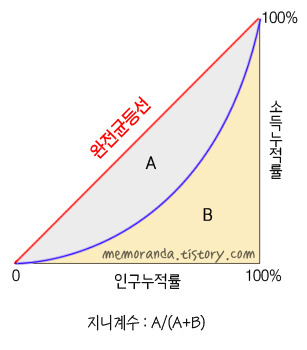

A가 좁을수록 평등

머신러닝에서는 모델의 예측 성능을 측정하는데 사용  
예측값을 크기순으로 정렬해서 로렌츠 곡선을 구함

정규화 지니계수=$\frac{예측값에 대한 지니계수}{예측이 완벽할 때의 지니계수}$  
예측값에 대한 지니계수: 예측값과 실제값으로 구한 지니계수  
예측이 완벽할 때의 지니계수: 실제값과 실제값으로 구한 지니계수

In [10]:
def eval_gini(y_true, y_pred) : 
    # 실제값과 예측값의 크기가 서로 같은지 확인(다르면 에러 발생)
    assert y_true.shape == y_pred.shape
    
    # 데이터 개수
    n_samples = y_true.shape[0]
    # 대각선 값 
    L_mid = np.linspace(1/n_samples, 1, n_samples)
    
    # 1. 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()]
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    G_pred = np.sum(L_mid - L_pred)
    
    # 2. 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()]
    L_true = np.cumsum(true_order) / np.sum(true_order)
    G_true = np.sum(L_mid - L_true)
    
    # 정규화된 지니계수
    return G_pred / G_true

모델 훈련 시 검증 파라미터에 전달하기 위한 함수

In [11]:
# LGBM용 gini() 함수
def gini(preds, dtrain) : 
    labels = dtrain.get_label()
     # 마지막 True는 값이 클수록 성능이 좋은지의 여부
    return 'gini', eval_gini(labels, preds), True

# 모델 훈련 및 성능 검증

**OOF 기법**
캐글에서 자주 사용하는 예측 기법  
K-fold CV를 수행하면서 각 fold마다 테스트 데이터로 예측하는 방식  
즉, 1. 훈련 데이터로 훈련 > 2. 검증 데이터로 성능 측정 > 3. 테스트 데이터로 최종 타깃 확률도 예측  

**OOF 예측 절차**  
- 전체 훈련 데이터를 K개의 그룹으로 분할  
- K개 그룹 중 한 그룹은 검증 데이터, 나머지 K-1개 그룹은 훈련 데이터로 지정  
- 훈련 데이터로 모델 훈련  
- 훈련된 모델을 이용해 검증 데이터로 타깃 확률을 예측하고, 전체 테스트 데이터로도 타깃 확률을 예측  
- 검증 데이터로 구한 예측 확률과 테스트 데이터로 구한 예측 확률 기록  
- 2~5번 절차를 K번 반복  
- K개 그룹의 검증 데이터로 예측한 확률을 훈련 데이터 실제 타깃값과 비교해 성능 평가 점수 계산  
- 테스트 데이터로 구한 K개의 예측 확률의 평균 계산  

**장점**  
- 오버피팅 방지  
- 앙상블 효과를 기대할 수 있음

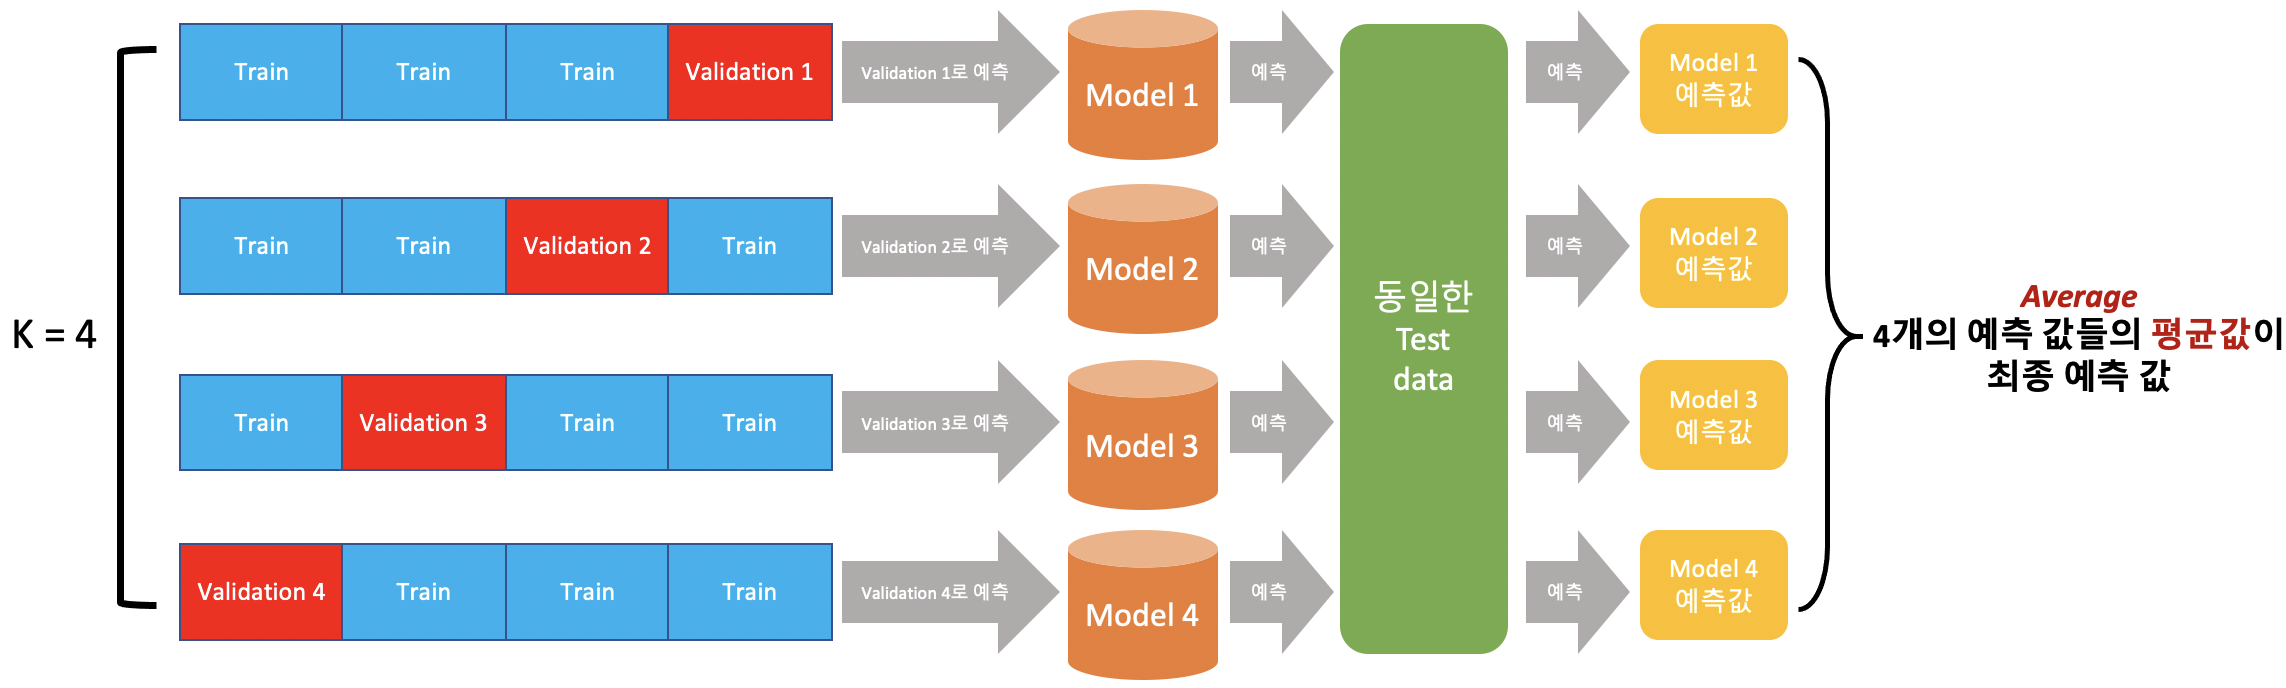

## LGBM 훈련

타깃이 불균형해서 층화 k-fold사용

In [12]:
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1991)

In [13]:
params = {'objective' : 'binary', 
          'learning_rate' : [0.01], 
          'force_row_wise' : [True], 
          'random_state' : [0]}

In [14]:
# OOF 방식으로 훈련된 모델을 통한 검증 데이터 타깃값 예측 확률
oof_val_preds = np.zeros(X.shape[0])

# OOF 방식으로 훈련된 모델을 통한 테스트 데이터 타깃값 예측 확률
oof_test_preds = np.zeros(X_test.shape[0])

In [15]:
import lightgbm as lgb 

# OOF 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) : 
    print('#'*40, f'폴드 {idx+1} / {folds.n_splits}', '#'*40)
    
    # train/valid 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # LGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid)
    
    # 훈련
    lgb_model = lgb.train(params = params,
                          train_set = dtrain, 
                          num_boost_round = 1000, # 부스팅 반복 횟수
                          valid_sets = dvalid, #성능 평가용 검증셋
                          feval = gini,
                          early_stopping_rounds = 100, #조기종류 조건
                          verbose_eval = 100)  # 100번째마다 점수 출력
    
    # 테스트 데이터를 통해 OOF 예측
    oof_test_preds += lgb_model.predict(X_test) / folds.n_splits
    
    # 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score} \n')

######################################## 폴드 1 / 5 ########################################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.153354	valid_0's gini: 0.261651
[200]	valid_0's binary_logloss: 0.152426	valid_0's gini: 0.275704
[300]	valid_0's binary_logloss: 0.152023	valid_0's gini: 0.282277
[400]	valid_0's binary_logloss: 0.1518	valid_0's gini: 0.286648
[500]	valid_0's binary_logloss: 0.151713	valid_0's gini: 0.287944
[600]	valid_0's binary_logloss: 0.151672	valid_0's gini: 0.288637
[700]	valid_0's binary_logloss: 0.151659	valid_0's gini: 0.288939
Early stopping, best iteration is:
[681]	valid_0's binary_logloss: 0.151659	valid_0's gini: 0.289034
폴드 1 지니계수 : 0.2890336154188232 

#########

# 예측 및 결과 제출

In [16]:
submission['target'] = oof_test_preds
submission.to_csv('submission_baseline.csv')

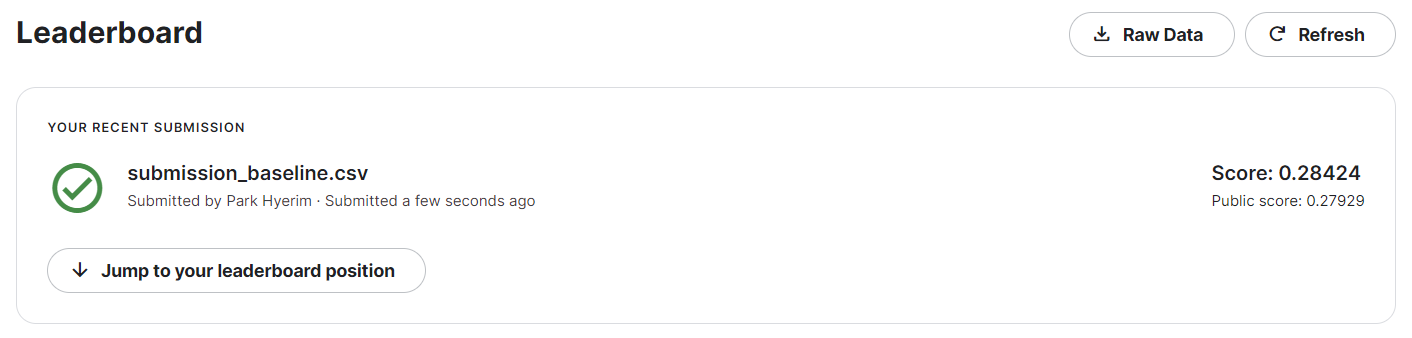

## 성능 개선1

### 파생 피처 추가

In [17]:
all_data['num_missing']=(all_data==-1).sum(axis=1)

In [18]:
remaining_features1=[feature for feature in all_data_features
                   if('cat' not in feature and 
                     'calc' not in feature)].append('num_missing')

remaining_features는 명목형 피처와 calc분류의 피처를 제외한 나머지 피처명으로 정의  
명목형은 원-핫 코딩을 할거라서 제외, calc은 필요없는 변수라는 사실을 EDA에서 알았기 때문에 제외

In [19]:
ind_features=[feature for feature in all_data_features if 'ind' in feature]
is_first_feature=True
for ind_feature in ind_features:
    if is_first_feature:
        all_data['mix_ind']=all_data[ind_feature].astype(str)+'_'
        is_first_feature=False
    else:
        all_data['mix_ind']+=all_data[ind_feature].astype(str)+'_'
    

In [24]:
 all_data['mix_ind']

id
7          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
9           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
13         5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
16          0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
17          0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488022     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488023    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488024     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488025    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488026    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

고윳값별 개수를 새로운 피처로 추가

In [21]:
all_data['ps_ind_02_cat'].value_counts().to_dict()

{1: 1079327, 2: 309747, 3: 70172, 4: 28259, -1: 523}

In [22]:
cat_count_features = [] 

for feature in cat_features + ['mix_ind'] : 
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: val_counts_dict[x])
    
    cat_count_features.append(f'{feature}_count')

In [30]:
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [32]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

In [31]:
cat_features + ['mix_ind']

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat',
 'mix_ind']

### 필요 없는 피처 제거

새롭게 만든 피처 목록  
- encoded_cat_matrix : 원-핫 인코딩된 명목형 피처  
- ramaining_features : 명목형 피처와 calc 분류의 피처를 제외한 피처들  
- cat_count_features : mix_ind를 포함한 명목형 피처의 고유값별 개수 파생 피처

In [37]:
all_data_remaining = all_data[remaining_features + cat_count_features]

# 데이터 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               encoded_cat], format = 'csr')

## 데이터 나누기

In [39]:
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

## 하라미터 최적화

In [40]:
import lightgbm as lgb 
from sklearn.model_selection import train_test_split 

X_train, X_valid, y_train, y_valid = \
train_test_split(X, y, test_size = 0.2, random_state = 0)

# 베이지안 최적화용 데이터셋 
bayes_dtrain = lgb.Dataset(X_train, y_train)
bayes_dvalid = lgb.Dataset(X_valid, y_valid)

1. 범위를 좁히기  
2. 상위 캐글러가 설정한거 참고

In [38]:
all_data['mix_ind']

id
7          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
9           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
13         5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
16          0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
17          0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488022     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488023    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488024     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488025    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488026    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

In [41]:
param_bounds = {'num_leaves' : (30, 40), 
                'lambda_l1' : (0.7, 0.9),
                'lambda_l2' : (0.9, 1),
                'feature_fraction' : (0.6, 0.7),
                'bagging_fraction' : (0.6, 0.9),
                'min_child_samples' : (6, 10), 
                'min_child_weight' : (10, 40)}

fixed_params = {'objective' : 'binary' ,
                'learning_rate' : 0.005,
                'bagging_freq' : 1, 
                'force_row_wise' : True,
                'random_state' : 1991}

**베이지안 최적화용 평가지표 계산 함수**

In [42]:
def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction,
                  bagging_fraction, min_child_samples, min_child_weight) : 
    
    # 베이지안 최적화를 수행할 하이퍼 파라미터 
    params = {'num_leaves' : int(round(num_leaves)), 
                'lambda_l1' : lambda_l1,
                'lambda_l2' : lambda_l2,
                'feature_fraction' : feature_fraction,
                'bagging_fraction' : bagging_fraction,
                'min_child_samples' : int(round(min_child_samples)), 
                'min_child_weight' : min_child_weight,
                'feature_pre_filter' : False}
    
    # 고정된 하이퍼 파라미터
    params.update(fixed_params)
    
    print('Hyper parameter : ', params)
    
    # LGBM 훈련 
    lgb_model = lgb.train(params = params,
                          train_set = bayes_dtrain,
                          num_boost_round = 2500, 
                          valid_sets = bayes_dvalid,
                          feval = gini, 
                          early_stopping_rounds = 300,
                          verbose_eval = False)
    
    # 검증 데이터로 예측 수행 
    preds = lgb_model.predict(X_valid)
    
    # 지니계수
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

## 최적화 수행

In [47]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f = eval_function, 
                                 pbounds = param_bounds,
                                 random_state = 0)

In [48]:
optimizer.maximize(init_points = 3, n_iter = 6)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
Hyper parameter :  {'num_leaves': 34, 'lambda_l1': 0.8205526752143287, 'lambda_l2': 0.9544883182996897, 'feature_fraction': 0.6715189366372419, 'bagging_fraction': 0.7646440511781974, 'min_child_samples': 8, 'min_child_weight': 29.376823391999682, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786
[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
지니계수 : 0.2846948890516193

|  1        |  0.2847   |  0.

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 17383, number of negative: 458786
[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
지니계수 : 0.2845693597584708

|  4        |  0.2846   |  0.8893   |  0.6621   |  0.7916   |  0.9731   |  8.5      |  39.08    |  39.55    |
Hyper parameter :  {'num_leaves': 37, 'lambda_l1': 0.7738449330497988, 'lambda_l2': 0.9032695189818599, 'feature_fraction': 0.6606341064409726, 'bagging_fraction': 0.7666713964943057, 'min_child_samples': 9, 'min_child_weight': 29.306172421380474, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
지니계수 : 0.2849581997239311

|  5        |  0.285    |  0.7667   |  0.6606   |  0.7738   |  0.9033   |  8.769    |  29.31    |  36.6     |
Hyper parameter :  {'num_leaves': 40, 'lambda_l1': 0.7113567244294035, 'lambda_l2': 0.9992148463611682, 'feature_fraction': 0.6823972673568225, 'bagging_fraction': 0.6452323984860321, 'min_child_samples': 9, 'min_child_weight': 36.23198396337493, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
지니계수 : 0.2849172300422476

|  6        |  0.2849   |  0.6452   |  0.6824   |  0.7114   |  0.9992   |  9.083    |  36.23    |  39.59    |
Hyper parameter :  {'num_leaves': 36, 'lambda_l1': 0.862092450221885, 'lambda_l2': 0.900511488097541, 'feature_fraction': 0.6556247435580953, 'bagging_fraction': 0.7236613926476847, 'min_child_samples': 8, 'min_child_weight': 16.800997543304433, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
지니계수 : 0.28419803259318527

|  7        |  0.2842   |  0.7237   |  0.6556   |  0.8621   |  0.9005   |  8.223    |  16.8     |  36.38    |
Hyper parameter :  {'num_leaves': 37, 'lambda_l1': 0.7587502056850454, 'lambda_l2': 0.9797829350356843, 'feature_fraction': 0.6954342923283758, 'bagging_fraction': 0.7409016193163251, 'min_child_samples': 9, 'min_child_weight': 29.079243263548527, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786
[LightGBM] [Info] Total Bins 1547

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
지니계수 : 0.28528403647084516

|  8        |  0.2853   |  0.7409   |  0.6954   |  0.7588   |  0.9798   |  8.676    |  29.08    |  36.63    |
Hyper parameter :  {'num_leaves': 40, 'lambda_l1': 0.8106236134604519, 'lambda_l2': 0.9370945684067623, 'feature_fraction': 0.6559186416905237, 'bagging_fraction': 0.8600135386288141, 'min_child_samples': 9, 'min_child_weight': 35.95851354029547, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
지니계수 : 0.2851782560846589

|  9        |  0.2852   |  0.86     |  0.6559   |  0.8106   |  0.9371   |  9.021    |  35.96    |  39.98    |


In [49]:
max_params = optimizer.max['params']
max_params

{'bagging_fraction': 0.6213108174593661,
 'feature_fraction': 0.608712929970154,
 'lambda_l1': 0.7040436794880651,
 'lambda_l2': 0.9832619845547939,
 'min_child_samples': 9.112627003799401,
 'min_child_weight': 36.10036444740457,
 'num_leaves': 39.78618342232764}

In [50]:
# 정수형 하이퍼파라미터 변환 
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))

In [51]:
# 고정된 하이퍼파라미트 추가
max_params.update(fixed_params)
max_params

{'bagging_fraction': 0.6213108174593661,
 'feature_fraction': 0.608712929970154,
 'lambda_l1': 0.7040436794880651,
 'lambda_l2': 0.9832619845547939,
 'min_child_samples': 9,
 'min_child_weight': 36.10036444740457,
 'num_leaves': 40,
 'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'force_row_wise': True,
 'random_state': 1991}

## 모델 훈련 및 검증

In [52]:
from sklearn.model_selection import StratifiedKFold

# 층화 K-Fold 교차 검증기 생성
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1991)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # LGBM dataset 
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid)
    
    # LGBM training 
    lgb_model = lgb.train(params = max_params, 
                          train_set = dtrain, 
                          num_boost_round = 2500,
                          valid_sets = dvalid,
                          feval = gini,
                          early_stopping_rounds = 300,
                          verbose_eval = 100)
    
    # OOF prediction using test data 
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # normalized gini coefficient for pred_proba for valid data 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    
    print(f'폴드 {idx+1} 지니계수. : {gini_score}\n')

######################################## Fold 1 / Fold 5 ########################################


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1546
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 215
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 300 rounds
[100]	valid_0's binary_logloss: 0.154258	valid_0's gini: 0.270867
[200]	valid_0's binary_logloss: 0.153181	valid_0's gini: 0.275152
[300]	valid_0's binary_logloss: 0.152588	valid_0's gini: 0.279513
[400]	valid_0's binary_logloss: 0.152215	valid_0's gini: 0.283589
[500]	valid_0's binary_logloss: 0.151977	valid_0's gini: 0.286877
[600]	valid_0's binary_logloss: 0.15183	valid_0's gini: 0.288869
[700]	valid_0's binary_logloss: 0.151712	valid_0's gini: 0.291003
[800]	valid_0's binary_logloss: 0.151624	valid_0's gini: 0.292833
[900]	valid_0's binary_logloss: 0.151564	valid_0's gini: 0.294054
[1000]	val

[LightGBM] [Info] Number of positive: 17355, number of negative: 458815
[LightGBM] [Info] Total Bins 1550
[LightGBM] [Info] Number of data points in the train set: 476170, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274766
[LightGBM] [Info] Start training from score -3.274766
Training until validation scores don't improve for 300 rounds
[100]	valid_0's binary_logloss: 0.154388	valid_0's gini: 0.268239
[200]	valid_0's binary_logloss: 0.153385	valid_0's gini: 0.272516
[300]	valid_0's binary_logloss: 0.152829	valid_0's gini: 0.276217
[400]	valid_0's binary_logloss: 0.152497	valid_0's gini: 0.2793
[500]	valid_0's binary_logloss: 0.152283	valid_0's gini: 0.282283
[600]	valid_0's binary_logloss: 0.152121	valid_0's gini: 0.2854
[700]	valid_0's binary_logloss: 0.152011	valid_0's gini: 0.28763
[800]	valid_0's binary_logloss: 0.151932	valid_0's gini: 0.289382
[900]	valid_0's binary_logloss: 0.151869	valid_0's gini: 0.290987
[1000]	valid_0

In [54]:
print(f'OOF 검증 데이터 지니계수 :' ,eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수 : 0.2889096122590669


## 예측 및 결과 제출

In [55]:
submission['target'] = oof_test_preds
submission.to_csv('submission_lgb.csv')

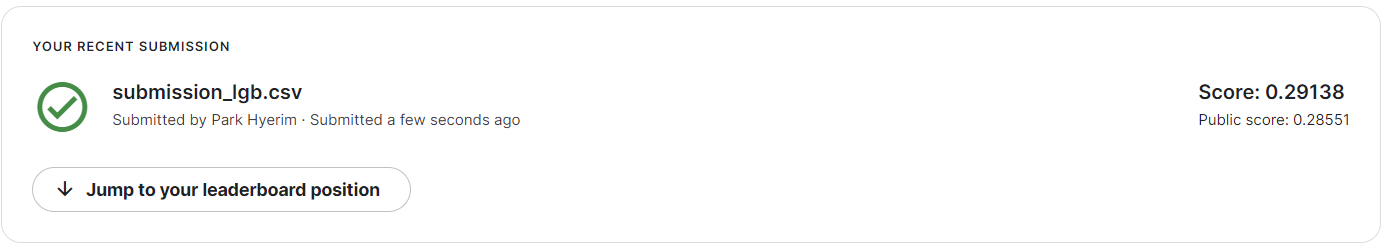